In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import stockstats as ss

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV

import random
import quandl

FEES = 0
def profitable(x):
    if x["change"] > 0 + FEES:
        return 1
    elif x["change"] <= 0 + FEES:
        return 0

In [13]:
#step 1: data download

btc = pd.read_csv("../Data/SPY_in_theory_from_1-01-00_to_1-26-19.csv")
print(btc.head())
print(type(btc))

'''
btc = quandl.get("BCHARTS/COINBASEUSD", authtoken="BEcxZbU_yoMRvS_55tEF")
btc = btc.drop(columns = ["Volume (Currency)", "Weighted Price"]).rename(index=str, columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume (BTC)": "volume"})
print(btc)
'''

'''
btc_close = quandl.get("BCHAIN/MKPRU", authtoken="BEcxZbU_yoMRvS_55tEF") #downloads btc close data
btc_close.columns = ["close"] #renames only column "value" to "close", btc_close.rename() also works

btc_vol = quandl.get("BCHAIN/ETRAV", authtoken="BEcxZbU_yoMRvS_55tEF") #downloads vol data
btc_vol.columns = ["volume"]

btc_change = btc_close/btc_close.shift(1) - 1
btc_change.columns = ["change"]

btc = btc_close.join([btc_vol, btc_change])
#btc_clean = btc[1:].dropna() #removes all rows containing any NaN values
btc_2011_2018 = btc.iloc[728:3650] #selects data from 2011-2018, pre-2011 data is not reliable

#print(btc_2011_2018)

#print(btc_close.iloc[600:,:]) #selects startrow:endrow, startcol:endcol
btc_2009 = btc.iloc[:363]
btc_2010 = btc.iloc[363:728]
btc_2011 = btc.iloc[728:1093]
btc_2012 = btc.iloc[1093:1459]
btc_2013 = btc.iloc[1459:1824]
btc_2014 = btc.iloc[1824:2189]
btc_2015 = btc.iloc[2189:2554]
btc_2016 = btc.iloc[2554:2920]
btc_2017 = btc.iloc[2920:3285]
btc_2018 = btc.iloc[3285:3650]
btc_2019 = btc.iloc[3650:]
#print(btc_2011)
'''

         Date        Open        High         Low     Close   Adj Close  \
0  2000-01-03  148.250000  148.250000  143.875000  145.4375  101.872139   
1  2000-01-04  143.531204  144.062500  139.640594  139.7500   97.888344   
2  2000-01-05  139.937500  141.531204  137.250000  140.0000   98.063423   
3  2000-01-06  139.625000  141.500000  137.750000  137.7500   96.487427   
4  2000-01-07  140.312500  145.750000  140.062500  145.7500  102.091049   

     Volume  
0   8164300  
1   8089800  
2  12177900  
3   6227200  
4   8066500  
<class 'pandas.core.frame.DataFrame'>


'\nbtc_close = quandl.get("BCHAIN/MKPRU", authtoken="BEcxZbU_yoMRvS_55tEF") #downloads btc close data\nbtc_close.columns = ["close"] #renames only column "value" to "close", btc_close.rename() also works\n\nbtc_vol = quandl.get("BCHAIN/ETRAV", authtoken="BEcxZbU_yoMRvS_55tEF") #downloads vol data\nbtc_vol.columns = ["volume"]\n\nbtc_change = btc_close/btc_close.shift(1) - 1\nbtc_change.columns = ["change"]\n\nbtc = btc_close.join([btc_vol, btc_change])\n#btc_clean = btc[1:].dropna() #removes all rows containing any NaN values\nbtc_2011_2018 = btc.iloc[728:3650] #selects data from 2011-2018, pre-2011 data is not reliable\n\n#print(btc_2011_2018)\n\n#print(btc_close.iloc[600:,:]) #selects startrow:endrow, startcol:endcol\nbtc_2009 = btc.iloc[:363]\nbtc_2010 = btc.iloc[363:728]\nbtc_2011 = btc.iloc[728:1093]\nbtc_2012 = btc.iloc[1093:1459]\nbtc_2013 = btc.iloc[1459:1824]\nbtc_2014 = btc.iloc[1824:2189]\nbtc_2015 = btc.iloc[2189:2554]\nbtc_2016 = btc.iloc[2554:2920]\nbtc_2017 = btc.iloc[29

In [14]:
# step 2: feature engineering

##this is a  very different process depending on data set
##here i'm calculating ~50 techincal financial indicators that i know nothing about

btc = ss.StockDataFrame.retype(btc) #coerces df into StockDataFrame again

#calculates and appends TA indicators to stock

btc['macd'] # calculate MACD indicator for the entire "btc" df and automatically appends to new column
btc['volume_delta']
btc['open_-1_r']
btc['cr']
btc['cr-ma1']
btc['cr-ma2']
btc['cr-ma3']
btc["rsi_6"]
btc["rsi_12"]
btc["wr_10"]
btc["cci"]
btc['tr']
btc['atr']
btc['dma']
btc['pdi']
btc['mdi']
btc['dx']
btc['adx']
btc['adxr']
btc['trix']
btc['trix_9_sma']
btc['vr']
btc.head()

#apply profitable function then clean dataset again
btc["profitable"] = btc.apply(profitable, axis=1) #adding column "profitable" where +1 represents price went up and 0 represents price went down
btc["profitable"] = btc["profitable"].shift(-1) #shifts "profitable" target column up 1 so current days stats predict tomorrow's profitability 

btc = btc[1:len(btc.index)-1] #removes first & last entry that now has NaN "profitable" column
btc = btc[1:].dropna() #removes all rows containing any NaN values
print(len(btc))
print(btc.head())

c:\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
c:\python36\lib\site-packages\stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: np.fabs(x - x.mean()).mean())
c:\python36\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


4785
                  open        high         low       close   adj close  \
date                                                                     
2000-01-18  145.343704  146.625000  145.187500  145.812500  102.134834   
2000-01-19  145.312500  147.000000  145.000000  147.000000  102.966591   
2000-01-20  146.968704  146.968704  143.812500  144.750000  101.390602   
2000-01-21  145.500000  145.500000  144.062500  144.437500  101.171661   
2000-01-24  145.656204  145.843704  139.406204  140.343704   98.304153   
2000-01-25  140.515594  141.937500  139.000000  141.937500   99.420578   
2000-01-26  141.000000  141.546799  140.093704  140.812500   98.632538   
2000-01-27  141.843704  142.218704  138.125000  140.250000   98.238579   
2000-01-28  139.437500  140.062500  135.531204  135.875000   95.174065   
2000-01-31  135.812500  139.671799  135.000000  139.562500   97.756981   
2000-02-01  139.750000  141.687500  138.531204  140.937500   98.720108   
2000-02-02  141.281204  142.25000

[4785 rows x 57 columns]


In [24]:
print(btc.head())

                  open        high         low       close   adj close  \
date                                                                     
2000-01-18  145.343704  146.625000  145.187500  145.812500  102.134834   
2000-01-19  145.312500  147.000000  145.000000  147.000000  102.966591   
2000-01-20  146.968704  146.968704  143.812500  144.750000  101.390602   
2000-01-21  145.500000  145.500000  144.062500  144.437500  101.171661   
2000-01-24  145.656204  145.843704  139.406204  140.343704   98.304153   

             volume  close_26_ema      macd     macds     macdh     ...      \
date                                                                ...       
2000-01-18  6488500    144.052910  0.437536  0.245332  0.384409     ...       
2000-01-19  6157900    144.415006  0.521630  0.304669  0.433922     ...       
2000-01-20  5800100    144.454251  0.449979  0.335422  0.229114     ...       
2000-01-21  6244800    144.452369  0.372391  0.343156  0.058470     ...       
2000-01

In [15]:
# step 3: data preprocessing

#create train-test sets, then std'ize and check lengths

y = btc["profitable"] #y is the variables that you are trying to predict, in this case it's binary form (1 or 0) + or - 0% price change from yesterday
x = btc.drop(["profitable", "change"], axis=1) #move drop until after split to track data for backtesting

import random
train_percent = 0.8
train_size = int(len(btc)*train_percent)
RANDOM_STATE = 123
random.seed(RANDOM_STATE)
#x_train_raw,x_test_raw,y_train,y_test = train_test_split(stock_month,y,test_size = .3,random_state = RANDOM_STATE)
x_train = x.iloc[:int(len(btc)*.8)] #.iloc[startrow:endrow, startcol:endcol]
x_test = x.iloc[int(len(btc)*.8):]
y_train = y.iloc[:int(len(btc)*.8)]
y_test = y.iloc[int(len(btc)*.8):]

x_std_train = (x_train - x_train.mean())/x_train.std()
x_std_test = (x_test - x_test.mean())/x_test.std()

x_std_train = x_std_train.drop(["open","high","low","close","volume"], axis=1)
x_std_test = x_std_test.drop(["open","high","low","close","volume"], axis=1)

print(x_train.shape)
print(x_test.shape)
print(x.shape)
print(x_train.shape[0]+x_test.shape[0])

(3828, 55)
(957, 55)
(4785, 55)
4785


c:\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy Score: 0.503657
F1 score:  0.5463228271251195


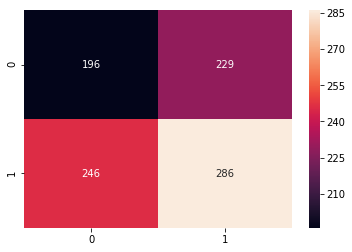

In [16]:
clf_rf = RandomForestClassifier(random_state = RANDOM_STATE, verbose=1)
clr_rf = clf_rf.fit(x_std_train,y_train)

predictions = clf_rf.predict(x_std_test)

ac = accuracy_score(predictions,y_test)
cm = confusion_matrix(predictions,y_test)

print('Accuracy Score: %f' % ac)
sns.heatmap(cm,annot = True,fmt = 'd')

f1 = f1_score(predictions, y_test)
#type(predictions)
print("F1 score: ", f1)

c:\python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 3200 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed: 21.0min finished
[Parallel(n_jobs=1)]: Using backend 

Accuracy Score: 0.539185
F1 score:  0.637633525061627
Best Params:  {'criterion': 'entropy', 'max_features': 42, 'min_samples_leaf': 48, 'oob_score': True, 'warm_start': True}


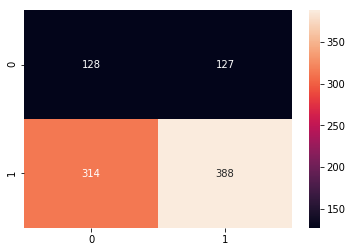

In [17]:
params = {'min_samples_leaf':range(10,50),
          'max_features':range(10,50),
          #'max_features':['sqrt','log2'],
          'warm_start':[True],
          'criterion':['entropy'],
          #'min_samples_split':range(2,10),
          'oob_score':[True,False]
          }
rf_model = GridSearchCV(clf_rf, param_grid=params, n_jobs=-1, verbose=True, scoring='accuracy')
rf_model = rf_model.fit(x_std_train,y_train)

predictions = rf_model.predict(x_std_test)

ac = accuracy_score(predictions,y_test)
cm = confusion_matrix(predictions,y_test)

print('Accuracy Score: %f' % ac)
sns.heatmap(cm,annot = True,fmt = 'd')

f1 = f1_score(predictions, y_test)
#type(predictions)
print("F1 score: ", f1)
print("Best Params: ", rf_model.best_params_)

In [85]:
params = {'min_samples_leaf':range(30,50),
          'max_features':range(10,30),
          #'max_features':['sqrt','log2'],
          'warm_start':[True],
          'criterion':['entropy'],
          #'min_samples_split':range(2,10),
          'oob_score':[True,False]
          }
rf_searched = GridSearchCV(clf_rf, param_grid=params, n_jobs=-1, verbose=True, scoring='accuracy')
rf_searched = rf_model.fit(x_std_train,y_train)

c:\python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 3200 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed:  6.4min finished
[Parallel(n_jobs=1)]: Using backend 

In [21]:
answers_df = pd.DataFrame(
    {'date': list(x["date"]),
    'close': list(x_test["close"]),
    'predictions': list(predictions)
    })

answers_df.to_csv("quandl_testing_SPY.csv")

KeyError: 'date'

In [23]:
print(type(x))

<class 'pandas.core.frame.DataFrame'>
